# The Lieb-Robinson lightcone

In this project we propose the way out of this difficulty. We propose to consider the Lieb-Robinson lightcone as a real-time alterantive to the equilibrium Gibbs distribution.  The Lieb-Robinson lightcone always exists in the condensed matter.  


## Example: Interaction quench for qubit (atom) in the waveguide

Let us illustrate it on a specific example. Suppose we have a qubit (two-level atom) with a transition frequency $E_{at}$. We suppose there is a laser driving $f(t) = 0.1 \cos(t)$ acting on the qubit. As a result, it fluoresces into the waveguide. The latter is represented as a bosonic chain with constant hoppings $h$ and on-site energies $\varepsilon$. The total Hamiltonian is:

$$
H\left(t\right) = E_{at}  \sigma_{z} + \sigma_{x} \cdot f(t) + h \sigma_{+} a_{0} + h a^{\dagger}_{0} \sigma_{-} + \sum\limits_{i=0}^{\infty} (\varepsilon a^{\dagger}_{i} a_{i} + h a^{\dagger}_{i+1} a_{i} + h a^{\dagger}_{i} a_{i+1})  
$$


Let us program this Hamiltonian:


In [1]:
# in python, we define this model in the following way:

# 1. We define the two-state Hilbert space of the qubit (atom)
# as one bosonic mode truncated at one excitation
import secondquant as sq
hs_atom = sq.fock_space(num_modes = 1, max_total_occupation = 1, statistics = 'Bose')

# 2. We define the Fock space of the waveguide (bosonic chain).
# We truncate it at
m = 9 # modes  and at a total occupation of
n = 7 #  quanta
fs_chain = sq.fock_space(num_modes = m, max_total_occupation = n, statistics = 'Bose') 

# 3. The joint Hilbert space is given by a tensor product:
hs_joint = sq.fock_space_kron(hs_atom, fs_chain)

# 4. The creation and annihilation operators are provided as
b_hat = hs_joint.annihilate
b_hat_dag = hs_joint.create

Here <code> b_hat[0] </code> and <code> b_hat_dag[0] </code> correspond to $\sigma_{-}$ and $\sigma_{+}$ of the qubit degree of freedom:

In [2]:
sigma_m = b_hat[0]
sigma_p = b_hat_dag[0]
sigma_x = hs_joint.sigmax(0)

Also, <code> b_hat[i + 1] </code> and <code> b_hat_dag[i + 1] </code> correspond to $a_{i}$ and $a^{\dagger}_{i}$ of the chain: 

In [3]:
a_hat = b_hat[1:]
a_hat_dag = b_hat_dag[1:]

Therefore, the Hamiltonian becomes:

In [11]:
Eat = 1.0
h = 0.05
e = 1.0
def f(t):
    return(0.1*np.cos(t))

Hconst = Eat * sigma_p @ sigma_m + h * sigma_p @ a_hat[0] + h * sigma_m @ a_hat_dag[0] \
    + e * sum([a_hat_dag[i] @ a_hat[i] for i in range(m)]) \
    + h * sum([a_hat_dag[i + 1] @ a_hat[i] + a_hat_dag[i] @ a_hat[i + 1] for i in range(m-1)])

def H(t):
    return Hconst + f(t) * sigma_x

Let us consider the interaction quench. That is, initially the qubit and the waveguide are in their ground states. The initial wavefunction <code> psi_ini </code> has only one non-zero component <code> psi_ini[0] </code> which corresponds to the ground state:

In [12]:
import numpy as np
K = hs_joint.dimension
psi_ini = np.zeros(K, dtype = complex)
psi_ini[0] = 1 

Then we suddenly turn on the interaction due to $H(t)$. As the result, the disturbance starts to propagate gradually along the waveguide. We can visualize it by solving the nonstationary Schrodinger equation 

$$
    i\frac{\partial \Psi\left(t\right)}{\partial t} = \widehat{H}\left(t\right)\Psi\left(t\right)
$$

and computing the occupations <code> ni[j, i] </code> of the  waveguide sites, <code> ni[j,i] </code> = $ n_j\left(t\right)=\left\langle\Psi\left(t_i\right)|a_j^{\dagger} a_j|\Psi\left(t_i\right)\right\rangle$:

In [13]:
import tools
tmax = 100
dt = 0.01
t = np.arange(start = 0, stop = tmax, step = dt)
nt = t.size
ni = np.zeros((m, nt))

# The midpoint Hamiltonian for time t = ti * dt
def Hi(ti):
    return H(ti * dt + dt/2)

# Solve the Schrodinger equation via implicit midpoint method on time grid
for i, psi in tools.evolution(start_index = 0, end_index = nt, H = Hi, dt = dt, initial_state = psi_ini):
    for j in range(m):
        ni[j, i] = (np.conj(psi) @ a_hat_dag[j]@a_hat[j] @ psi).real



Let us visualize the grid <code> ni[j, i] </code>:

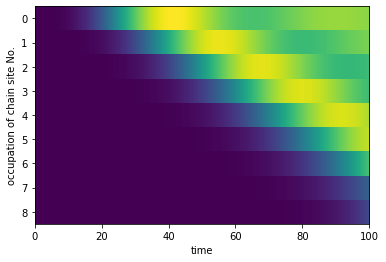

In [14]:
import matplotlib.pyplot as plt
 
plt.imshow(ni, cmap='viridis',  aspect='auto', interpolation = 'none')
plt.xlabel('time')
plt.ylabel('chain site No.')
plt.xticks([0, 2000, 4000, 6000, 8000, 10000], labels=["0", "20", "40", "60", "80", "100"])
plt.show()


We observe the lightcone-like spread of disturbance.  

## Lightcone allows us to identify the relevant and irrelevant degrees of freedom

The domain outside the lightcone consists of degrees of freedom which will become significantly excited only in the future. More specifically, for each chain site $i$ there is a time moment $t_i$ after which it will become statistically significant for the evolution. We may define a piece-wise continuous function $m\left(t\right)$ which shows how many sites have coupled to the evolution by the time $t$:

$$
m(t) = \max\{t_i : t_i <= t\}
$$

Then when solving the Schrodinger equation, we can include only a finite number $m\left(t\right)$ of sites into the Hamiltonian:

$$
    i\frac{\partial \Psi\left(t\right)}{\partial t} = \widehat{H}_m\left(t\right)\Psi\left(t\right)
$$

with

$$
H_m\left(t\right) = E_{at}  \sigma_{z} + \sigma_{x} \cdot f(t) + h \sigma_{+} a_{0} + h a^{\dagger}_{0} \sigma_{-} + \sum\limits_{i=0}^{m\left(t\right)} (\varepsilon a^{\dagger}_{i} a_{i} + h a^{\dagger}_{i+1} a_{i} + h a^{\dagger}_{i} a_{i+1})  
$$ (lightcone_restricted_ham)




## Find the time of a new incoming chain site

We can find the time $t_i$ using the results of the preceding computation. We introduce a treshold of significance $a_{cut}$. Then the time $t_i$ is defined as a first time when the occupation of the site $i$ exceeds the  threshold,

$$
    n_i\left(t\right) > a_{cut}  
$$

Here is the program:

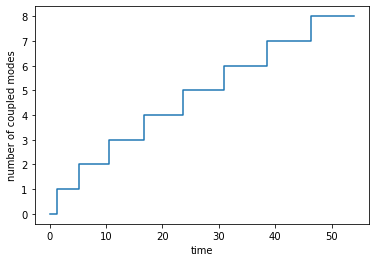

In [21]:
#| label:aposteriory_estimate

a_cut = 10**(-5)

ti = [0]
for i in range(m):
    ti.append(np.argmax(ni[i, :] - a_cut > 0))
ti.append(nt-1)
    
x = []
y = []

for i in range(m):
    x.append(t[ti[i]])
    x.append(t[ti[i+1]])
    y.append(i)
    y.append(i)

plt.xlabel('time')
plt.ylabel('number of coupled modes')

plt.plot(x, y)

Now let us solve the Schrodinger equation with the full number of modes and compute the 
occupation of the qubit: <code> nq[i] </code>=$\left\langle\Psi\left(t_i\right)|\sigma_+ \sigma_-|\Psi\left(t_i\right)\right\rangle$
    

Text(0, 0.5, 'occupation of qubit')

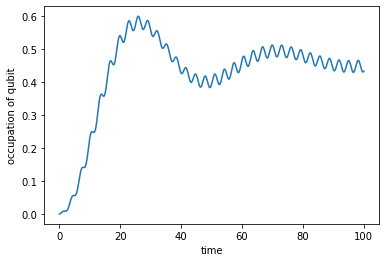

In [16]:
nq = np.zeros(nt)

for i, psi in tools.evolution(start_index = 0, end_index = nt, H = Hi, dt = dt, initial_state = psi_ini):
    nq[i] = (np.conj(psi) @ sigma_p @ sigma_m @ psi).real
              
plt.plot(t, nq)
plt.xlabel('time')
plt.ylabel('occupation of qubit')


Then let us solve the Schrodinger equation but now keeping only $m\left(t\right)$ modes:

Text(0, 0.5, 'occupation of qubit')

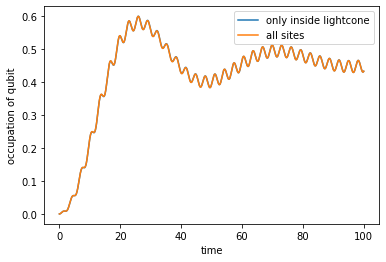

In [23]:
nq2 = np.zeros(nt)

psi_begin = np.copy(psi_ini)

for j in range(len(ti)-1):
    a = ti[j]
    b = ti[j+1]
    
    Hmconst = Eat * sigma_p @ sigma_m + h * sigma_p @ a_hat[0] + h * sigma_m @ a_hat_dag[0] \
        + e * sum([a_hat_dag[i] @ a_hat[i] for i in range(j)]) \
        + h * sum([a_hat_dag[i + 1] @ a_hat[i] + a_hat_dag[i] @ a_hat[i + 1] for i in range(j-1)])
    
    def Hm(t):
        return Hmconst + f(t) * sigma_x
    
    def Hmi(ti):
        return H(ti * dt + dt/2)
    
    for i, psi in tools.evolution(start_index = a, end_index = b, H = Hmi, dt = dt, initial_state = psi_begin):
        nq2[i] = (np.conj(psi) @ sigma_p @ sigma_m @ psi).real
        
    psi_begin = psi
              
plt.plot(t[:-2], nq2[:-2], label = 'only inside lightcone')
plt.plot(t, nq, label = 'all sites')
plt.legend()
plt.xlabel('time')
plt.ylabel('occupation of qubit')

We see that the lightcone works!